# Training a simple CNN model in Tensorflow for Tornado Detection

This notebook steps through how to train a simple CNN model using a subset of TorNet.

This will not produce a model with any skill, but simply provides a working end-to-end example of how to set up a data loader, build, and fit a model


In [ ]:
import sys
# Uncomment if tornet isn't installed in your environment or in your path already
#sys.path.append('../')  

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tornet.data.tf.loader import create_tf_dataset 
from tornet.data.constants import ALL_VARIABLES
import tornet.data.preprocess as pp
from tornet.data import preprocess as tfpp
import keras
from tornet.data.constants import CHANNEL_MIN_MAX
import tornet.metrics.keras.metrics as km

In [ ]:
def classify_region(row):
    tornado_alley_bounds = {
    'lat_min': 32.0,
    'lat_max': 43.0,
    'lon_min': -102.0,
    'lon_max': -94.0
}

    dixie_alley_bounds = {
        'lat_min': 30.0,
        'lat_max': 38.0,
        'lon_min': -94.0,
        'lon_max': -83.0
    }
    if (
        tornado_alley_bounds['lat_min'] <= row['lat'] <= tornado_alley_bounds['lat_max'] and
        tornado_alley_bounds['lon_min'] <= row['lon'] <= tornado_alley_bounds['lon_max']
    ):
        return 2  # Tornado Alley
    elif (
        dixie_alley_bounds['lat_min'] <= row['lat'] <= dixie_alley_bounds['lat_max'] and
        dixie_alley_bounds['lon_min'] <= row['lon'] <= dixie_alley_bounds['lon_max']
    ):
        return 1  # Dixie Alley
    else:
        return 0  # None

In [ ]:
import os
import pandas as pd

def load_dataset(data_root, data_type, years, variables, random_state=1234):
    """
    Load and prepare the dataset from the given catalog and file list.

    Args:
        data_root (str): Path to the root directory containing the catalog and data files.
        data_type (str): Type of data to load (e.g., 'train' or 'test').
        years (list): List of years to filter the catalog.
        variables (list): List of variables for the dataset.
        random_state (int): Seed for shuffling.

    Returns:
        tf.data.Dataset: TensorFlow dataset prepared from the file list.
    """
    catalog_path = os.path.join(data_root, 'catalog.csv')
    if not os.path.exists(catalog_path):
        raise RuntimeError(f'Unable to find catalog.csv at {data_root}')

    catalog = pd.read_csv(catalog_path, parse_dates=['start_time', 'end_time'])
    catalog = catalog[catalog['type'] == data_type]
    catalog = catalog[catalog.start_time.dt.year.isin(years)]
    catalog['region'] = catalog.apply(classify_region, axis=1)
    catalog = catalog[catalog['region'] == 1]
    catalog = catalog.sample(frac=1, random_state=random_state)

    file_list = [os.path.join(data_root, f) for f in catalog.filename]
    return create_tf_dataset(file_list, variables=variables)

# Location of tornet
data_root = "C:/Users/mjhig/tornet_2013"

# Get training dataset
years = [2013, 2014, 2015, 2016, 2017, 2018]
ds = load_dataset(data_root, data_type='train', years=years, variables=ALL_VARIABLES)
ds = ds.map(lambda d: pp.add_coordinates(d, include_az=False, backend=tf))
ds = ds.map(pp.remove_time_dim)
ds = ds.map(tfpp.split_x_y)
ds = ds.prefetch(tf.data.AUTOTUNE)
ds = ds.batch(32)
# Get test dataset
ds_test = load_dataset(data_root, data_type='test', years=years, variables=ALL_VARIABLES)
# preprocess
ds_test = ds_test.map(lambda d: pp.add_coordinates(d,include_az=False,backend=tf))
ds_test = ds_test.map(pp.remove_time_dim)
ds_test = ds_test.map(tfpp.split_x_y)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)



import os
import pandas as pd
import tensorflow as tf
from collections import Counter
def load_dataset(data_root, data_type, years, variables, random_state=1234):
    """
    Load and prepare the dataset from the given catalog and file list.

    Args:
        data_root (str): Path to the root directory containing the catalog and data files.
        data_type (str): Type of data to load (e.g., 'train' or 'test').
        years (list): List of years to filter the catalog.
        variables (list): List of variables for the dataset.
        random_state (int): Seed for shuffling.

    Returns:
        tf.data.Dataset: TensorFlow dataset prepared from the file list.
    """
    catalog_path = os.path.join(data_root, 'catalog.csv')
    if not os.path.exists(catalog_path):
        raise RuntimeError(f'Unable to find catalog.csv at {data_root}')

    catalog = pd.read_csv(catalog_path, parse_dates=['start_time', 'end_time'])
    catalog = catalog[catalog['category'] == 'TOR']
    catalog = catalog[catalog['type'] == data_type]
    catalog = catalog[catalog.start_time.dt.year.isin(years)]
    catalog['region'] = catalog.apply(classify_region, axis=1)
    catalog=catalog[catalog.region != 0]
    catalog = catalog.sample(frac=1, random_state=random_state)

    file_list = [os.path.join(data_root, f) for f in catalog.filename]
    return create_tf_dataset(file_list, variables=variables)


def new_x_y(d):
    """
    Splits dict into X,y, where y are tornado labels
    """
    print(d['coordinates'])
    y=classify_region(d)
    return d,y


# Location of tornet
data_root = "C:/Users/mjhig/tornet_2013"

# Define years and variables
years = [2013, 2014, 2015]

# Get training dataset
ds = load_dataset(data_root, data_type='train', years=years, variables=ALL_VARIABLES)
ds = ds.map(lambda d: pp.add_coordinates(d, include_az=False, backend=tf))
ds = ds.map(pp.remove_time_dim)

def classify_region(row):
    tornado_alley_bounds = {
    'lat_min': 32.0,
    'lat_max': 43.0,
    'lon_min': -102.0,
    'lon_max': -94.0
}

    dixie_alley_bounds = {
        'lat_min': 30.0,
        'lat_max': 38.0,
        'lon_min': -94.0,
        'lon_max': -83.0
    }
    if (
        tornado_alley_bounds['lat_min'] <= row['lat'] <= tornado_alley_bounds['lat_max'] and
        tornado_alley_bounds['lon_min'] <= row['lon'] <= tornado_alley_bounds['lon_max']
    ):
        return 2  # Tornado Alley
    elif (
        dixie_alley_bounds['lat_min'] <= row['lat'] <= dixie_alley_bounds['lat_max'] and
        dixie_alley_bounds['lon_min'] <= row['lon'] <= dixie_alley_bounds['lon_max']
    ):
        return 1  # Dixie Alley
    else:
        return 0  # None

def new_x_y(d):
    """
    Splits dict into X,y, where y are tornado labels
    """
    print(d['coordinates'])

ds = ds.map(new_x_y)
# ds = ds.prefetch(tf.data.AUTOTUNE)
# ds = ds.batch(32)



# Get test dataset
ds_test = load_dataset(data_root, data_type='test', years=years, variables=ALL_VARIABLES)
ds_test = ds_test.map(lambda d: pp.add_coordinates(d,include_az=False,backend=tf))
ds_test = ds_test.map(pp.remove_time_dim)
ds_test = ds_test.map(tfpp.split_x_y)
ds_test = filter_positive_tornado_cases(ds_test)  # Filter by positive tornado cases
ds_test = set_target_to_region(ds_test)          # Set the target to 'region'
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras


def create_model(architecture):
    """Create a CNN model with different architectures."""
    inputs = {v: keras.Input(shape=(120, 240, 2), name=v) for v in ALL_VARIABLES}
    norm_layers = []
    for v in ALL_VARIABLES:
        min_max = np.array(CHANNEL_MIN_MAX[v])
        var = ((min_max[1] - min_max[0]) / 2) ** 2
        var = np.array(2 * [var])
        offset = (min_max[0] + min_max[1]) / 2
        offset = np.array(2 * [offset])
        norm_layers.append(
            keras.layers.Normalization(mean=offset, variance=var, name=f'Normalized_{v}')
        )
    x = keras.layers.Concatenate(axis=-1, name='Concatenate1')(
        [l(inputs[v]) for l, v in zip(norm_layers, ALL_VARIABLES)]
    )
    x = keras.layers.Lambda(lambda x: tf.where(tf.math.is_nan(x), -3.0, x), name='ReplaceNan')(x)
    
    if architecture == "baseline":
        x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    elif architecture == "deeper":
        x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    elif architecture == "residual":
        x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x= keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    elif architecture == "wide":
        x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    elif architecture == "dropout":
        x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = keras.layers.Dropout(0.5)(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    else:
        raise ValueError("Unknown architecture type")
    
    y = keras.layers.GlobalMaxPool2D(name='GlobalMaxPool')(x)
    return keras.Model(inputs=inputs, outputs=y, name=f'TornadoDetector_{architecture}')

# Train and evaluate different models
architectures = ["baseline", "deeper", "residual", "wide", "dropout"]

model = create_model("baseline")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(from_logits=True))
model.fit(ds, epochs=4, steps_per_epoch=10)



In [ ]:
# Evaluate
import tornet.metrics.keras.metrics as km
metrics = [keras.metrics.AUC(from_logits=True,name='AUC'),
           km.BinaryAccuracy(from_logits=True,name='BinaryAccuracy'), 
           ]
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=metrics)

# steps=10 for demo purposes
model.evaluate(ds_test,steps=10)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap_with_input_gradients(model_inputs, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model_inputs)  # Watch the inputs to compute gradients
        conv_outputs, predictions = grad_model(model_inputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients with respect to the inputs
    input_grads = tape.gradient(class_channel, model_inputs)

    # Gradients with respect to the last conv layer
    conv_grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(conv_grads, axis=(0, 1, 2))  # Average gradients over width and height
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Sum across channels

    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negative values
    if tf.reduce_max(heatmap) > 0:
        heatmap /= tf.reduce_max(heatmap)  # Normalize heatmap to [0, 1]

    return np.array(heatmap), input_grads




# Unpack the dataset
for sample in ds_test.take(1):  # Take a single batch from the dataset
    inputs, _ = sample  # Assuming the dataset is structured as (features, labels)
    break

# Prepare the list of inputs for the model
model_inputs = [
    inputs['DBZ'], 
    inputs['VEL'], 
    inputs['KDP'], 
    inputs['RHOHV'], 
    inputs['ZDR'], 
    inputs['WIDTH']
]

# Generate heatmap and input gradients
heatmap, input_grads = make_gradcam_heatmap_with_input_gradients(model_inputs, model, 'TornadoLikelihood')

# Calculate the importance of each input
input_importance = [tf.reduce_mean(tf.abs(grad)).numpy() for grad in input_grads]

# Map input names to their importance
input_names = ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']
input_importance_dict = dict(zip(input_names, input_importance))

# Print or plot the importance of each input
print("Input importance:", input_importance_dict)


c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['DBZ', 'KDP', 'RHOHV', 'VEL', 'WIDTH', 'ZDR']]. Received: the structure of inputs=['*', '*', '*', '*', '*', '*']
  warnings.warn(


Input importance: {'DBZ': 3.2751348e-07, 'VEL': 4.2211e-06, 'KDP': 2.3816998e-05, 'RHOHV': 2.1884564e-07, 'ZDR': 3.404607e-06, 'WIDTH': 3.5826592e-06}
tf.Tensor([1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1], shape=(32,), dtype=uint8)
Most important regions for DBZ:
Shape of importance map: (120, 240)
(120, 240)


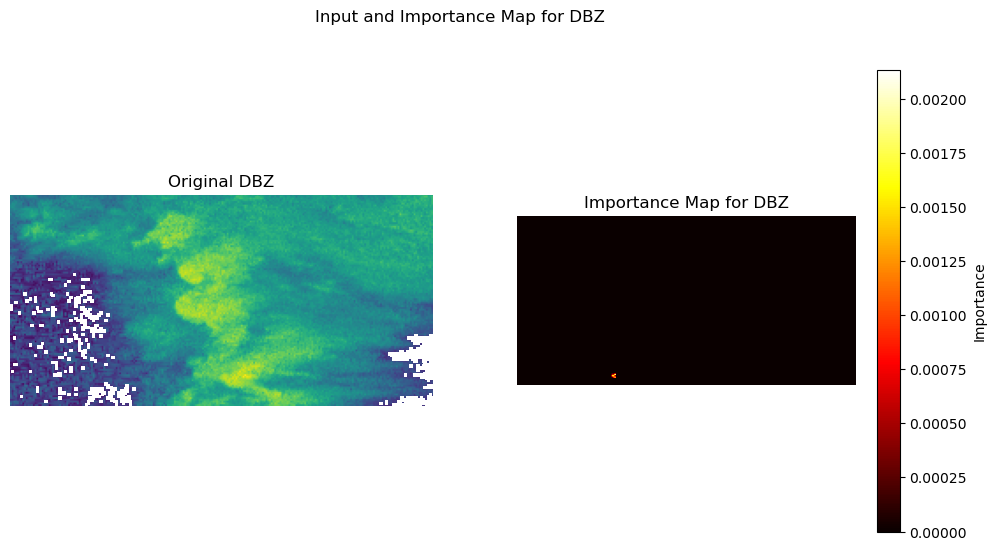

tf.Tensor([1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1], shape=(32,), dtype=uint8)
Most important regions for VEL:
Shape of importance map: (120, 240)
(120, 240)


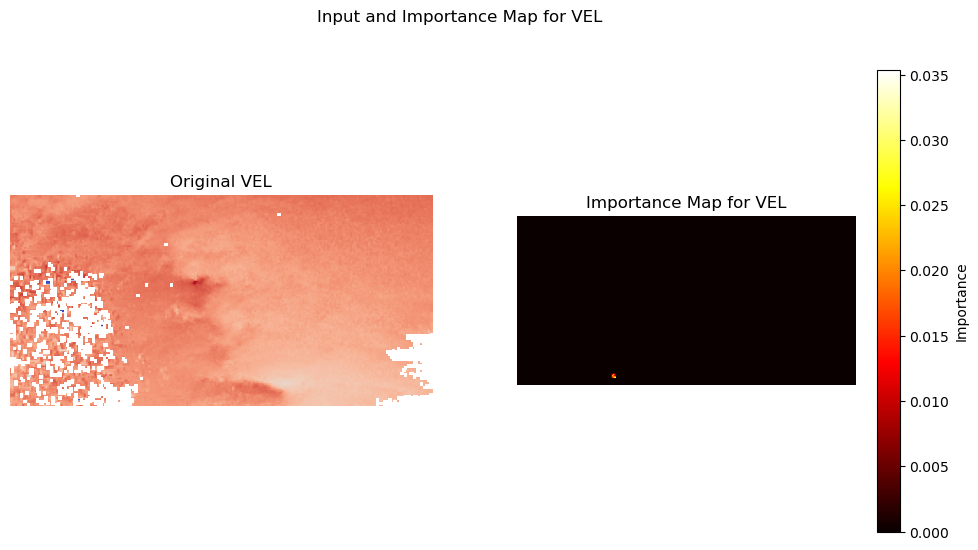

tf.Tensor([1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1], shape=(32,), dtype=uint8)
Most important regions for KDP:
Shape of importance map: (120, 240)
(120, 240)


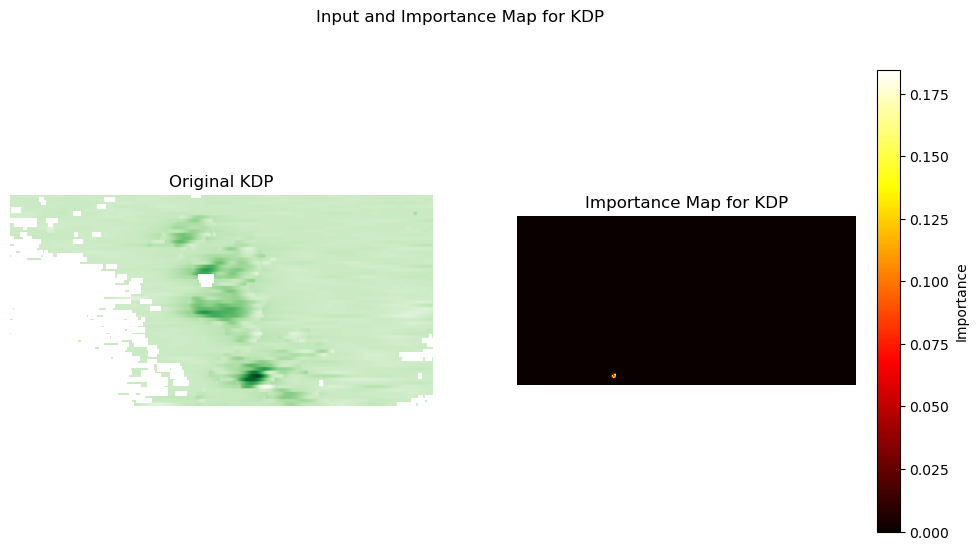

tf.Tensor([1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1], shape=(32,), dtype=uint8)
Most important regions for RHOHV:
Shape of importance map: (120, 240)
(120, 240)


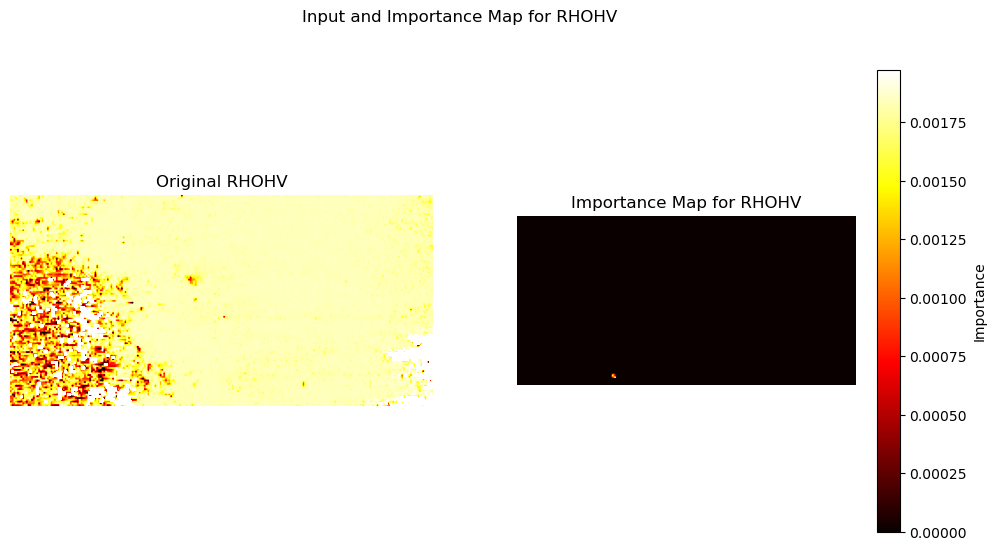

tf.Tensor([1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1], shape=(32,), dtype=uint8)
Most important regions for ZDR:
Shape of importance map: (120, 240)
(120, 240)


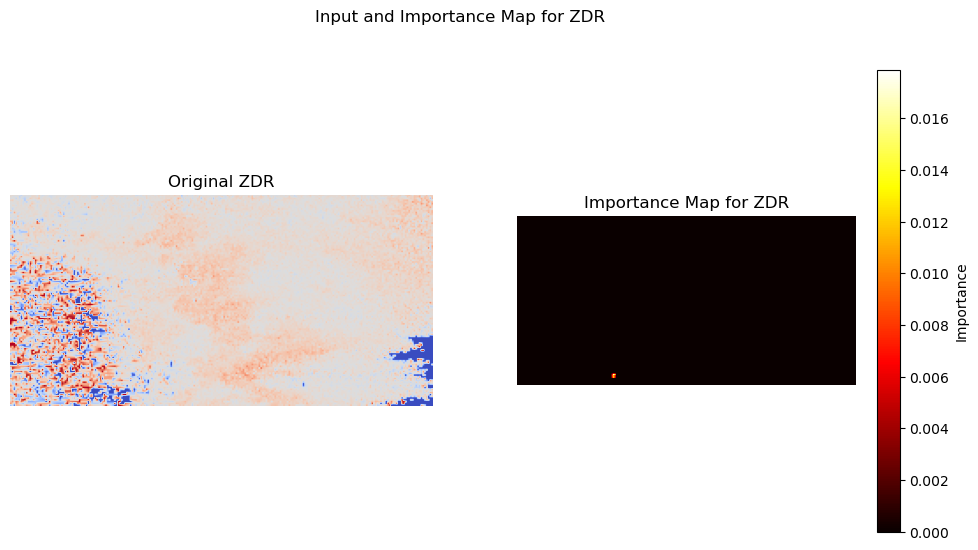

tf.Tensor([1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1], shape=(32,), dtype=uint8)
Most important regions for WIDTH:
Shape of importance map: (120, 240)
(120, 240)


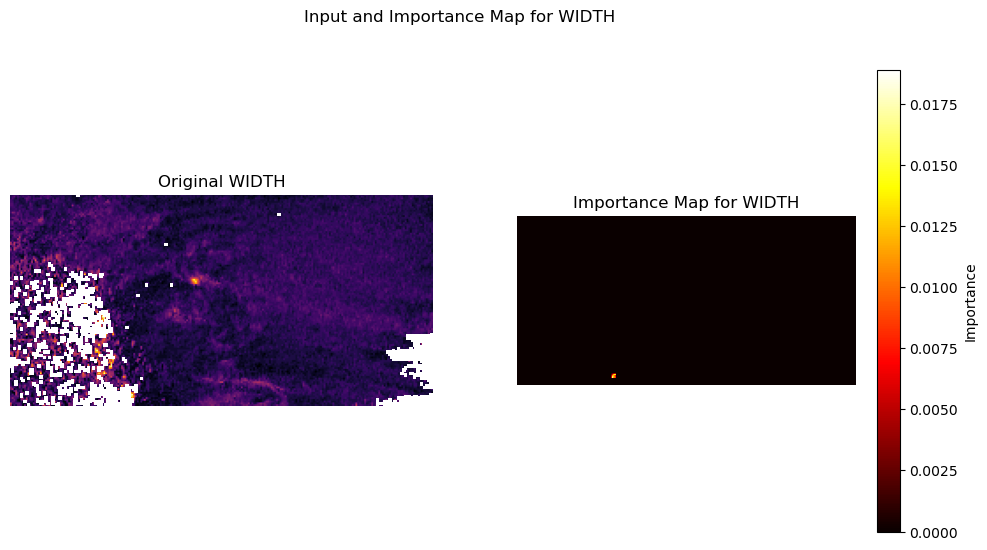

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap_with_input_gradients(model_inputs, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model_inputs)  # Watch the inputs to compute gradients
        conv_outputs, predictions = grad_model(model_inputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients with respect to the inputs
    input_grads = tape.gradient(class_channel, model_inputs)

    # Gradients with respect to the last conv layer
    conv_grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(conv_grads, axis=(0, 1, 2))  # Average gradients over width and height
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Sum across channels

    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negative values
    if tf.reduce_max(heatmap) > 0:
        heatmap /= tf.reduce_max(heatmap)  # Normalize heatmap to [0, 1]

    return np.array(heatmap), input_grads

# Unpack the dataset
for sample in ds_test.take(1):  # Take a single batch from the dataset
    inputs, y = sample  # Assuming the dataset is structured as (features, labels)
    break

# Prepare the list of inputs for the model
model_inputs = [
    inputs['DBZ'], 
    inputs['VEL'], 
    inputs['KDP'], 
    inputs['RHOHV'], 
    inputs['ZDR'], 
    inputs['WIDTH']
]

# Generate heatmap and input gradients
heatmap, input_grads = make_gradcam_heatmap_with_input_gradients(model_inputs, model, 'TornadoLikelihood')

# Calculate the importance of each input
input_importance = [tf.reduce_mean(tf.abs(grad)).numpy() for grad in input_grads]

# Map input names to their importance
input_names = ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']
radar_cmap_mapping = {
    "DBZ": "viridis",  # Reflectivity
    "VEL": "coolwarm",  # Velocity
    "KDP": "Greens",    # Specific Differential Phase
    "RHOHV": "hot",     # Correlation Coefficient
    "ZDR": "coolwarm",  # Differential Reflectivity
    "WIDTH": "inferno"  # Spectrum Width
}
input_importance_dict = dict(zip(input_names, input_importance))

print("Input importance:", input_importance_dict)

# Analyze and plot each input slice
for i, grad in enumerate(input_grads):
    input_name = input_names[i]

    # Compute mean absolute gradient for each spatial location
    grad_abs_mean = tf.reduce_mean(tf.abs(grad), axis=-1).numpy()  # Shape: (batch_size, height, width)

    # Select the most important regions for the first sample in the batch
    important_regions = grad_abs_mean[0]  # First sample in batch
    input_data = model_inputs[i][7]
    print(y)
    input_data=input_data[..., 0] 
    print(f"Most important regions for {input_name}:")
    print("Shape of importance map:", important_regions.shape)
    print(input_data.shape)
    # Visualize the input data and importance map side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), edgecolor='k')
    fig.suptitle(f"Input and Importance Map for {input_name}")

    # Plot the original input
    input_name = input_names[i]
    axes[0].imshow(input_data,cmap=radar_cmap_mapping[input_name])
    axes[0].set_title(f"Original {input_name}")
    axes[0].axis('off')

    # Plot the importance map
    im = axes[1].imshow(important_regions, cmap="hot")
    axes[1].set_title(f"Importance Map for {input_name}")
    axes[1].axis('off')

    # Add colorbar to the importance map
    fig.colorbar(im, ax=axes[1], label="Importance")
    plt.show()


In [ ]:
from tornet.display.display import plot_radar
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap_with_input_gradients(model_inputs, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model_inputs)  # Watch the inputs to compute gradients
        conv_outputs, predictions = grad_model(model_inputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients with respect to the inputs
    input_grads = tape.gradient(class_channel, model_inputs)

    # Gradients with respect to the last conv layer
    conv_grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(conv_grads, axis=(0, 1, 2))  # Average gradients over width and height
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Sum across channels

    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negative values
    if tf.reduce_max(heatmap) > 0:
        heatmap /= tf.reduce_max(heatmap)  # Normalize heatmap to [0, 1]

    return np.array(heatmap), input_grads




# Unpack the dataset
for sample in ds_test.take(1):  # Take a single batch from the dataset
    inputs, _ = sample  # Assuming the dataset is structured as (features, labels)
    break

# Prepare the list of inputs for the model
model_inputs = [
    inputs['DBZ'], 
    inputs['VEL'], 
    inputs['KDP'], 
    inputs['RHOHV'], 
    inputs['ZDR'], 
    inputs['WIDTH']
]

# Generate heatmap and input gradients
heatmap, input_grads = make_gradcam_heatmap_with_input_gradients(model_inputs, model, 'TornadoLikelihood')

# Calculate the importance of each input
input_importance = [tf.reduce_mean(tf.abs(grad)).numpy() for grad in input_grads]

# Map input names to their importance
input_names = ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']
input_importance_dict = dict(zip(input_names, input_importance))

# Print or plot the importance of each input
print("Input importance:", input_importance_dict)


# Analyze each input slice
for i, grad in enumerate(input_grads):
    input_name = input_names[i]

    # Compute mean absolute gradient for each spatial location
    grad_abs_mean = tf.reduce_mean(tf.abs(grad), axis=-1).numpy()  # Shape: (batch_size, height, width)

    # Select the most important regions for the first sample in the batch
    important_regions = grad_abs_mean[0]  # First sample in batch

    print(f"Most important regions for {input_name}:")
    print("Shape of importance map:", important_regions.shape)

    # Visualize the importance map
    fig = plt.figure(figsize=(12,6),edgecolor='k')
    plt.title(f"Importance Map for {input_name}")
    #plot_radar(data=important_regions,fig=fig,channels=ALL_VARIABLES)
    plt.imshow(important_regions, cmap="hot")
    plt.colorbar(label="Importance")
    plt.show()
